# Baltimore infrastructure analysis

By [Christine Zhang](mailto:czhang@baltsun.com)

An analysis of water main break data from the Baltimore City Department of Public Works, the [Maryland Reported Sewer Overflow Database](https://mde.maryland.gov/programs/water/compliance/pages/reportedseweroverflow.aspx) from the Maryland Department of the Environment and the [311 Customer Service requests](https://data.baltimorecity.gov/City-Services/311-Customer-Service-Requests/9agw-sxsr) dataset from Open Baltimore for the Dec. 18, 2018 Baltimore Sun story, ["By the numbers: The toll winter takes on Baltimore's infrastructure"](https://www.baltimoresun.com/news/maryland/bs-md-infrastructure-by-the-numbers-20181211-story.html).

Here were some data points presented in the story:

- In January 2018, there were 508 water main breaks across the city and Baltimore County (including three dozen over the course of a single day), the most in single month since at least 2015.

- Approximately 189 million gallons of sewage-tainted water have flowed into the city’s waterways so far this year.

- According to the city’s 311 records, which date back to 2014, thirty percent of all pothole requests or repairs over the period happen in February or March.

## How we did it

### Import R data analysis libraries

In [1]:
suppressMessages(library('tidyverse'))
suppressMessages(library('data.table'))
suppressMessages(library('downloader'))
suppressMessages(library('janitor'))
suppressMessages(library('ggridges'))
suppressMessages(library('lubridate'))
suppressMessages(library('forcats'))
suppressMessages(library('scales'))
suppressMessages(library('sf'))

### Read in the data

The Baltimore City Department of Public Works provided the water main break data, which covers the period from Jan. 2015 through Nov. 2018, via email.

The sewage overflows data was exported from the [Maryland Reported Sewer Overflow Database](https://mde.maryland.gov/programs/water/compliance/pages/reportedseweroverflow.aspx) — all types of overflows during 2018 for Baltimore City. **Note:** data from years prior to 2018 are not comparable/complete. Also, per the Department of Public Works, overflows listed as less than 100 gallons were listed as 99 gallons in 2018.

The 311 calls dataset was downloaded on Dec. 11, 2018 from [Open Baltimore](https://data.baltimorecity.gov/City-Services/311-Customer-Service-Requests/9agw-sxsr). Because of the size of this (~3.4 million rows), it is not included in this repo. The information is updated several times daily.

In [2]:
main_breaks <- read.csv('input/Water Main Breaks 121418.csv', stringsAsFactors = F) %>% clean_names()
overflows <- read.csv('input/export_results.csv', stringsAsFactors = F) %>% clean_names()
calls_data <- fread('../311_Customer_Service_Requests.csv')

## In January 2018, there were 508 water main breaks across the city and Baltimore County (including three dozen over the course of a single day), the most in single month since at least 2015.

Use `lubridate` functions to extra year, month, day from the `date_time_initiated` column in the `main_breaks` dataframe.

In [7]:
main_breaks$date <- mdy_hm(main_breaks$date_time_initiated)
main_breaks$year <- year(main_breaks$date)
main_breaks$month <- month(main_breaks$date)
main_breaks$day <- day(main_breaks$date)

Use `group_by()` to create a dataframe, `main_breaks.grouped`, that groups the water main breaks and calculates the number each month and year. `arrange(desc(n))` arranges the number of water main breaks per month & year from highest to lowest.

In [8]:
main_breaks.grouped <- 
    main_breaks %>%
    group_by(month, year) %>% 
    summarise(n = n()) %>% 
    arrange(desc(n))

Use `head()` to see the month-year combinations with the highest number of water main breaks. 

In [12]:
main_breaks.grouped %>% head()

month,year,n
1,2018,508
2,2015,229
1,2015,209
12,2017,178
3,2015,168
1,2016,162


There were 508 water main breaks in January 2018 — the highest number since at least 2015 (the earliest year in the dataset).

Make a bar graph of 12-months of water main breaks from Nov. 2017 through Nov. 2018 to show the spike.

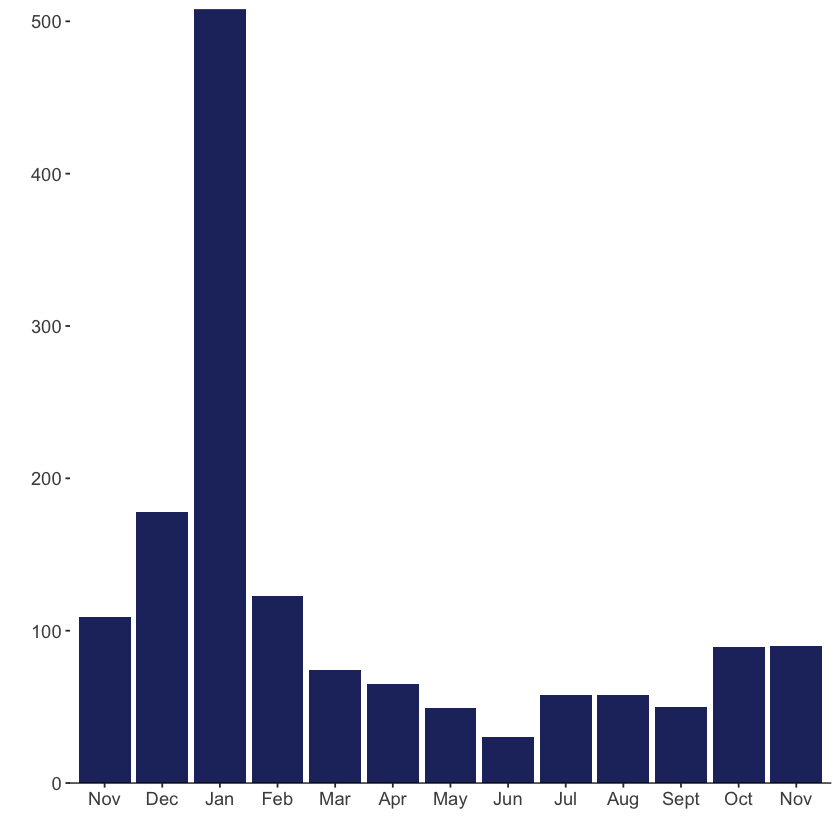

In [14]:
main_breaks.grouped <- main_breaks.grouped %>% 
                       mutate(month.year = paste0(month, '-', year))

main_breaks.grouped.subset <- main_breaks.grouped %>% filter((year == 2017 & month >= 11) | 
                                        (year == 2018) )

month_levels <- c(
  "11-2017", "12-2017", "1-2018", "2-2018", "3-2018", "4-2018", 
  "5-2018", "6-2018", "7-2018", "8-2018", "9-2018", "10-2018", "11-2018"
)

main_breaks.grouped.subset <- main_breaks.grouped.subset %>% 
                              mutate(month.year.f = parse_factor((month.year), 
                                                                  month_levels))

ggplot(main_breaks.grouped.subset, 
       aes(x = month.year.f, y = n)) +
geom_bar(stat = 'identity', fill = '#22316C') +
 theme(
       axis.text = element_text(size = 11)
 ) + theme(panel.grid.minor.x = element_blank(),
           axis.line.x = element_line(color = 'black'),
           panel.background = element_blank(),
           plot.title = element_text(size = 18, face = 'bold'),
           plot.subtitle = element_text(size = 14),
           plot.caption = element_text(hjust = -.01, color = 'grey30', size = 10)
 ) + labs (x = '' , y = '') +
scale_x_discrete(labels = c(
                'Nov',
                'Dec',
                'Jan',
                'Feb',
                'Mar',
                'Apr',
                'May',
                'Jun',
                'Jul',
                'Aug',
                'Sept',
                'Oct', 'Nov')) +
scale_y_continuous(expand = c(0 , 0))

# Save as .eps for editing in Illustrator
ggsave('output/plot.eps', width = 8, height = 6, device = 'eps')

To get water main breaks by day, use `group_by()` to create a dataframe, `main_breaks.grouped.day`.

In [16]:
main_breaks.grouped.day <- 
    main_breaks %>%
    group_by(month, year, day) %>% 
    summarise(n = n()) %>% 
    arrange(desc(n))

In [19]:
main_breaks.grouped.day %>% filter(year == 2018 & month == 1) %>% head()

month,year,day,n
1,2018,6,36
1,2018,8,27
1,2018,19,23
1,2018,13,22
1,2018,17,21
1,2018,7,20


There were 36 water main breaks over the course of a single day: Jan. 8, 2018. You can more about that here: https://www.baltimoresun.com/news/weather/bs-md-ci-water-main-breaks-20180102-story.html

## Approximately 189 million gallons of sewage-tainted water have flowed into the city’s waterways so far this year.

Use `sum()` on the `quan_gals_gross` column to view the the total gallons of outflows for 2018.

In [24]:
sum(overflows$quan_gals_gross, na.rm = T)

[1] 189313957

This sums to more than 189 million. **Note** however that this is an *estimate.* DPW *estimates* the total overflow using a different tools, one of which is an app. Take a look at the distribution of overflow amounts entered into this column:

In [28]:
overflows %>% group_by(quan_gals_gross) %>% summarise(n = n()) %>% arrange(desc(n)) %>% head()

quan_gals_gross,n
99,117
5,16
4,11
1000,8
0,7
3,7


"99" gallons is by far the most frequently reported amount. According to an email from Jeffrey Raymond at the Department of Public Works: "The app that we use to send the data to MDE listed everything less than 100 gallons as 99. This summer we updated the app to show the actual numbers."

Save a shapefile to put into a map of Baltimore City overflows > 100 gallons on CartoDB (see the map in the story: https://www.baltimoresun.com/news/maryland/bs-md-infrastructure-by-the-numbers-20181211-story.html). The `st_join()` function from the `sf` package is used to filter the dataset to places with geographical coordinates inside the city itself.

In [38]:
url <- 'http://bniajfi.org/wp-content/uploads/2014/04/csa_2010_boundaries.zip'
download(url, dest='shapes.zip', mode = 'wb')
unzip('shapes.zip', exdir=getwd())

neigborhoods <- st_read('CSA_NSA_Tracts.shp')

overflows.geo <- overflows %>% filter(!is.na(latitude)) %>% 
                           mutate(long = ifelse(longitude > 0, 
                                                longitude * -1,   
                                                longitude))

overflows.geo_spatial <- overflows.geo %>% 
  st_as_sf(coords = c("long", "latitude"), 
           crs = "+proj=longlat",
           remove = F) %>% 
  st_transform(crs=st_crs(neigborhoods))

points_in <- st_join(neigborhoods,
                     overflows.geo_spatial, left = T)


overflows.geo_spatial <- overflows.geo_spatial %>% 
                         mutate(watershed2 = ifelse(watershed == "", " ", watershed),
                                quan_gals_gross2 = comma(quan_gals_gross))

write_csv(overflows.geo_spatial %>% 
                filter(year == 2018 & 
                       location %in% points_in$location & 
                       quan_gals_gross > 99) %>% 
                      select(-longitude), 'output/overflows_18_baltcity_geo.csv')

Reading layer `CSA_NSA_Tracts' from data source `/Users/czhang/Documents/infrastructure/sharing/CSA_NSA_Tracts.shp' using driver `ESRI Shapefile'
Simple feature collection with 56 features and 3 fields
geometry type:  POLYGON
dimension:      XY
bbox:           xmin: 1393927 ymin: 557733.6 xmax: 1445551 ymax: 621406.8
epsg (SRID):    NA
proj4string:    +proj=lcc +lat_1=38.3 +lat_2=39.45 +lat_0=37.66666666666666 +lon_0=-77 +x_0=399999.9999999999 +y_0=0 +datum=NAD83 +units=us-ft +no_defs


## According to the city’s 311 records, which date back to 2014, thirty percent  of all pothole requests or repairs over the period happen in February or March.

Filter the `calls_data` dataframe to include only records with `SRType` (i.e., "Service Request Type") containing the word "Pothole" and save into a dataframe called `water.leaks`.

In [31]:
potholes <- calls_data %>% filter(grepl('Pothole',
                                          SRType))

According to the [311 call center](https://311services.baltimorecity.gov/), (which — meta! — you can call to ask questions about the 311 dataset), "TRM-Pothole repair" refers to a citizen call requesting a pothole be repaired, and "TRM-Pickup Pothole" is an internal designation referring to instances  where transportation maintenance fixes a pothole themselves (for example, en route to a "TRM-Pothole repair" job). We will keep this 

In [32]:
table(potholes$SRType)


TRM-Pickup Pothole TRM-Pothole Repair 
             31121              48904 

Delete duplicated records, i.e., calls that reference the same issue as another call.

In [33]:
potholes <- potholes %>% filter(!grepl('Duplicate', SRStatus))

Save `CreatedDate`, the date the call record was created, as a column in date format, `create_date`. Also put the month and year into columns `create_month` and `create_year`.

In [34]:
potholes$create_date <- as.POSIXct(potholes$CreatedDate, format = "%m/%d/%Y %I:%M:%S %p")
potholes$create_month <- month(potholes$create_date)
potholes$create_year <- year(potholes$create_date)

Group by `create_month` and use `summarise()` and `mutate()` to get the number and percentage of pothole 311 requests by month.

In [35]:
potholes.grouped <- potholes %>% group_by(create_month) %>% 
                                 summarise(n = n()) %>% 
                                 mutate(perc = n/sum(n) * 100) %>%
                                 arrange(desc(n))

potholes.grouped

create_month,n,perc
3,12407,15.863092
2,11017,14.085894
4,7993,10.219529
1,6944,8.878319
5,6928,8.857863
6,5746,7.346605
8,4937,6.312250
7,4822,6.165216
12,4496,5.748405
10,4396,5.620549


Use `filter()` to see the percentage of requests that come in during either February or March.

In [36]:
potholes.grouped %>% filter(create_month == 2 |
                            create_month == 3) %>% summarise(perc.sum = sum(perc))

perc.sum
29.94899
